<a href="https://colab.research.google.com/github/joaochenriques/IST---Marine-Currents-and-Tidal-Energy/blob/main/Tidal_Stream/BladeElementMethod/BladeDesign_V08.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [302]:
import subprocess
import pandas as pd
import pathlib
import numpy as np
from scipy.optimize import minimize, root_scalar
from copy import deepcopy

def cmdcall( cmd, verbose = False ):
    output = subprocess.getoutput( cmd )
    if verbose: print(output)

if not pathlib.Path("mpl_utils.py").exists():
  cmdcall( "curl -O https://raw.githubusercontent.com/joaochenriques/ipynb_libs/main/mpl_utils.py" )

import matplotlib.pyplot as mpl
import mpl_utils as mut
mut.config_plots()

from matplotlib_inline.backend_inline import set_matplotlib_formats
set_matplotlib_formats('svg')

In [303]:
rad2deg = 180/np.pi
deg2rad = np.pi/180

def SinDist( i: int, n: int, ang0_deg: float = 0 ) -> float:
    if i == n-1: return 1
    if i == 0: return 0
    csi0 = ang0_deg * deg2rad
    dcsi = ( np.pi - 2 * csi0 ) * i / ( n-1 )
    return ( ( np.cos( np.pi - csi0 - dcsi ) + 1.0 ) * 0.5 )

In [304]:
class Data:

    def __init__( self, λ_hub, λ_tip, dλ ):
        n = int( ( λ_tip - λ_hub ) / dλ + 0.5 ) + 1
        self.n       = n
        self.λ_hub   = λ_hub
        self.λ_tip   = λ_tip

        # self.λ_vec   = np.linspace( λ_hub, λ_tip, n )
        self.λ_vec   = np.zeros( n )
        for i in range( n ):
            self.λ_vec[i] = (self.λ_tip - self.λ_hub ) * SinDist( i, n ) + self.λ_hub

        self.a_vec   = np.zeros( n )
        self.ap_vec  = np.zeros( n )
        self.k_vec  = np.zeros( n )
        self.ϕ_vec   = np.zeros( n )
        self.σCL_vec = np.zeros( n )
        self.CP_vec  = np.zeros( n )
        self.CP_tip  = 0.0

In [305]:
_λ_hub = 0.4
_λ_tip = 7.0
_dλ = 0.2

dti = Data( _λ_hub, _λ_tip, _dλ ) # data for inviscid flow

print( f'r_hub / R_tip = {_λ_hub/_λ_tip:0.3f}' )

r_hub / R_tip = 0.057


## Glauert optimal distribution

C_P = 0.5787 -> Glauert


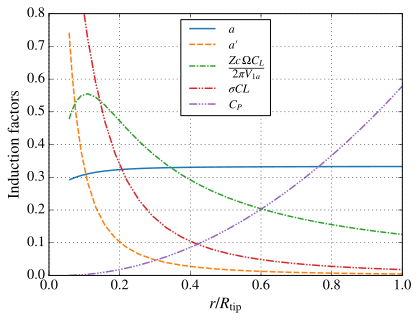

In [306]:

def f(y):
    return -64/5 * y**5 - 72 * y**4 - 124 * y**3 - 38 * y**2 + 63 * y + 12 * np.log(y) + 4 / y

def Integral_f( y2, y1, λ_tip ):
    return 8 / ( 729 * λ_tip**2 ) * ( f(y2) - f(y1) )

CP = 0

for i, λ in enumerate( dti.λ_vec ):

    func = lambda a: 16 * a**3 - 24 * a**2 + 3 * ( 3 - λ**2 ) * a + ( λ**2 - 1 )
    a = root_scalar(func, bracket=[ 1.0/4.0, 1.0/3.0 ], method='brentq' ).root
    ap = ( 1.0 - 3 * a ) / ( 4 * a - 1 )

    ϕ = np.arctan( ( 1 - a ) / ( 1 + ap ) / λ )
    σCL  = 4.0 * ap * λ / np.sqrt( ( 1.0 - a )**2 + ( 1.0 + ap )**2 * λ**2 )

    dti.a_vec[i] = a
    dti.ap_vec[i] = ap
    dti.ϕ_vec[i] = ϕ
    dti.σCL_vec[i] = σCL

    if i > 0:
        dti.CP_vec[i] = CP = CP + Integral_f( 1 - 3*dti.a_vec[i], 1 - 3*dti.a_vec[i-1], dti.λ_tip )

x_vec = dti.λ_vec / dti.λ_tip

mpl.plot( x_vec, dti.a_vec,  label = r"$a$" )
mpl.plot( x_vec, dti.ap_vec, label = r"$a\prime$" )
mpl.plot( x_vec, dti.σCL_vec*dti.λ_vec, label = r"$\dfrac{Zc\,\Omega C_L}{2\pi V_{1a}}$" )
mpl.plot( x_vec, dti.σCL_vec, label = r"$\sigma CL$" )
mpl.plot( x_vec, dti.CP_vec, label = r"$C_P$" )

mpl.xlabel( r"$r/R_\mathrm{tip}$")
mpl.ylabel( "Induction factors")
mpl.legend( loc="upper center", fontsize=12, handlelength=2.8, \
            labelspacing=0.4 )
mpl.grid()
mpl.ylim( ( 0.0, 0.8 ) )
mpl.savefig( "InductionFactors.pdf" )
print( f"C_P = {dti.CP_vec[-1]:.4f} -> Glauert" )

In [307]:
df = pd.DataFrame( { r"$\lambda$": dti.λ_vec,
                     r"$a$": dti.a_vec,
                     r"$a'$": dti.ap_vec,
                     r"$\phi$": dti.ϕ_vec*rad2deg,
                     r"$C_P$": dti.CP_vec,
                     r"$\frac{Zc\,\Omega C_L}{2\pi V_{1a}}$": dti.σCL_vec*dti.λ_vec,
                     r"$\sigma C_L$": dti.σCL_vec
                    } )

# print( df.to_latex(index=False,
#        formatters=["{:.2f}".format,"{:.5f}".format,"{:.5f}".format, \
#                    "{:.2f}".format,"{:.3f}".format,"{:.4f}".format]
# ))
df

,$\lambda$,$a$,$a'$,$\phi$,$C_P$,"$\frac{Zc\,\Omega C_L}{2\pi V_{1a}}$",$\sigma C_L$
0,0.400000,0.291898,0.741707,45.465727,0.000000,0.477863,1.194657
1,0.414943,0.292944,0.705400,44.976235,0.000084,0.485649,1.170400
2,0.459635,0.295894,0.611828,43.543212,0.000367,0.505865,1.100580
3,0.533673,0.300248,0.493826,41.274903,0.000937,0.530358,0.993787
4,0.636386,0.305328,0.379618,38.351935,0.001946,0.549292,0.863143
5,0.766843,0.310468,0.283612,35.011638,0.003608,0.555085,0.723858
6,0.923863,0.315163,0.209137,31.510861,0.006186,0.544927,0.589836
7,1.106025,0.319142,0.153933,28.078640,0.009974,0.520706,0.470790
8,1.311678,0.322340,0.113972,24.880840,0.015281,0.486975,0.371261
9,1.538960,0.324822,0.085320,22.010263,0.022411,0.448658,0.291533


## Computing the turbine blade (Glauert's solution)

In [308]:
def airfoil_data( α, Wm = None ):
    α *= rad2deg
    # CL = 0.368 + 0.094 * α
    # CD = 0.00994 + 0.000259 * α + 0.0001055 * α**2
    CL = 0.953
    CD = 0.00512
    return CL, CD

In [309]:
Z = 3
α  = 6.09 * deg2rad
CL, CD = airfoil_data( α )
CL, CD

(0.953, 0.00512)

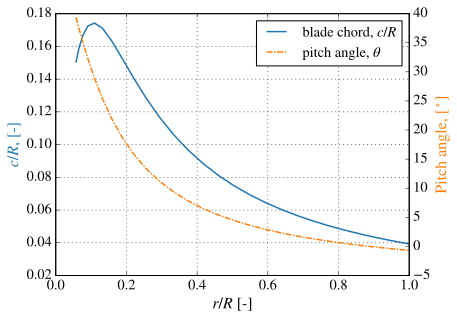

In [310]:
σCL_factor = 2.0 * np.pi / ( Z * CL )

θ_vec = dti.ϕ_vec - α
cR_vec = dti.σCL_vec * σCL_factor *  dti.λ_vec / dti.λ_tip
rR_vec = dti.λ_vec / dti.λ_tip

ax1 = mpl.gca()
ax1.plot( rR_vec, cR_vec, mut.linecolors[0], label=r"blade chord, $c/R$" )
ax1.set_ylabel( r"$c/R$, [-]", color=mut.linecolors[0] )
ax1.set_xlabel( r"$r/R$ [-]")
ax1.grid()
# ax1.set_ylim( 0, 0.25 )

ax2 = mpl.gca().twinx()
ax2.plot( rR_vec, θ_vec * rad2deg, mut.linecolors[1], \
          dashes=mut.linestyles[2], label=r'pitch angle, $\theta$' )
ax2.tick_params(axis='y' )
ax2.set_ylabel( r"Pitch angle, [$^\circ$]", color=mut.linecolors[1] )
# ax2.set_ylim( 0, 50 )
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines1 + lines2, labels1 + labels2, loc='upper right' )

mpl.savefig( "TurbineBlade.pdf" )

In [311]:
def tip_loss( a, ap, ϕ, λ, λtip ):
    ff = 0.5 * Z * ( λtip / λ - 1 ) * np.sqrt( 1 + ( λ / (1-a) )**2 )
    rr =  np.max( ( 2.0 / np.pi * np.arccos( np.exp( -ff ) ), 1E-3 ) )
    return rr

In [318]:
# The initial viscous solution is the invisc flow results
dtv = deepcopy( dti ) # deepcopy avoids references

for i, λ in enumerate( dti.λ_vec ):

    a = dti.a_vec[i]
    ap = dti.ap_vec[i]
    σ = dti.σCL_vec[i] / CL

    for j in range( 100 ):

        a_mo = a
        ap_mo = ap

        ϕ = np.atan2( ( 1 - a ), ( 1 + ap ) * λ )
        cosϕ = np.cos( ϕ )
        sinϕ = np.sin( ϕ )

        Ca = CL * cosϕ + CD * sinϕ
        Ct = CL * sinϕ - CD * cosϕ

        a  = σ * Ca / ( 4 * sinϕ**2 + σ * Ca )
        ap = σ * Ct / ( 4 * sinϕ*cosϕ - σ * Ct )

        if np.abs( a - a_mo ) < 1E-6 and np.abs( ap - ap_mo ) < 1E-6:
            break

    k = tip_loss( a, ap, ϕ, λ, dtv.λ_tip )

    dtv.a_vec[i] = a
    dtv.ap_vec[i] = ap
    dtv.k_vec[i] = k
    dtv.σCL_vec[i] = dti.σCL_vec[i] * k

# integrate CP using trapezoidal rule
CP = 0
fct = 8 / dtv.λ_tip**2
for i in range( 1, len( dti.λ_vec ) ):
    k = i - 1
    d_λ = dtv.λ_vec[i] - dtv.λ_vec[k]
    f_k = dtv.k_vec[k] * dtv.ap_vec[k] * ( 1 - dtv.a_vec[k] ) * dtv.λ_vec[k]**3
    f_i = dtv.k_vec[i] * dtv.ap_vec[i] * ( 1 - dtv.a_vec[i] ) * dtv.λ_vec[i]**3
    dtv.CP_vec[i] = CP = CP + fct * 0.5 * ( f_i + f_k ) * d_λ

print( f"C_P = {CP:.4f} -> Viscous flow" )

C_P = 0.5095 -> Viscous flow


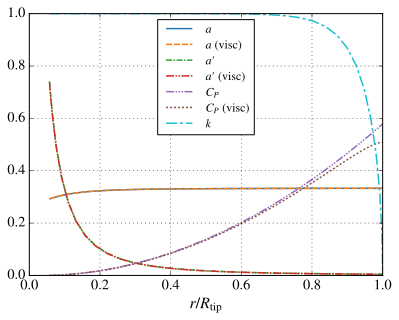

In [319]:
rR_vec = dtv.λ_vec / dtv.λ_tip

mpl.plot( rR_vec, dti.a_vec,  label = r"$a$" )
mpl.plot( rR_vec, dtv.a_vec,  label = r"$a$ (visc)" )
mpl.plot( rR_vec, dti.ap_vec, label = r"$a\prime$" )
mpl.plot( rR_vec, dtv.ap_vec, label = r"$a\prime$ (visc)" )
mpl.plot( rR_vec, dti.CP_vec, label = r"$C_P$" )
mpl.plot( rR_vec, dtv.CP_vec, label = r"$C_P$ (visc)" )
mpl.plot( rR_vec, dtv.k_vec, label = r"$k$" )

mpl.xlabel( r"$r/R_\mathrm{tip}$")
mpl.legend( loc="upper center", fontsize=12, handlelength=2.8, \
            labelspacing=0.4 )
mpl.grid()
# mpl.ylim( ( 0.0, 1.05 ) )
mpl.savefig( "InductionFactors.pdf" )

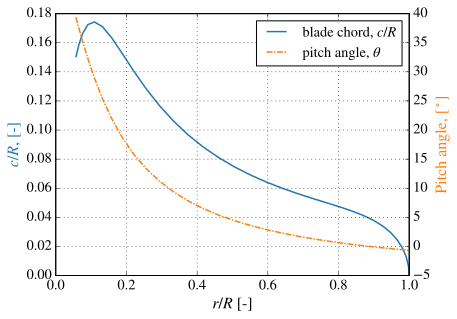

In [314]:
θ_vec = dtv.ϕ_vec - α
cR_vec = dtv.σCL_vec * σCL_factor *  dtv.λ_vec / dtv.λ_tip
rR_vec = dtv.λ_vec / dtv.λ_tip

mpl.figure(4)
ax1 = mpl.gca()
ax1.plot( rR_vec, cR_vec, mut.linecolors[0], label=r"blade chord, $c/R$" )
ax1.set_ylabel( r"$c/R$, [-]", color=mut.linecolors[0] )
ax1.set_xlabel( r"$r/R$ [-]")
ax1.grid()
# ax1.set_ylim( 0, 0.25 )

ax2 = mpl.gca().twinx()
ax2.plot( rR_vec, θ_vec * rad2deg, mut.linecolors[1], \
          dashes=mut.linestyles[2], label=r'pitch angle, $\theta$' )
ax2.tick_params(axis='y' )
ax2.set_ylabel( r"Pitch angle, [$^\circ$]", color=mut.linecolors[1] )
# ax2.set_ylim( 0, 50 )
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines1 + lines2, labels1 + labels2, loc='upper right' )

mpl.savefig( "TurbineBlade_visc.pdf" )

In [315]:
df = pd.DataFrame( { r"$\lambda$": dtv.λ_vec,
                     r"$a$": dtv.a_vec,
                     r"$a'$": dtv.ap_vec,
                     r"$\phi$": dtv.ϕ_vec*rad2deg,
                     r"$\frac{Zc\,\Omega C_L}{2\pi V_{1a}}$": dtv.σCL_vec*dtv.λ_vec,
                     r"$\sigma C_L$": dtv.σCL_vec
                    } )

# print( df.to_latex(index=False,
#        formatters=["{:.2f}".format,"{:.5f}".format,"{:.5f}".format, \
#                    "{:.2f}".format,"{:.3f}".format,"{:.4f}".format]
# ))
df

,$\lambda$,$a$,$a'$,$\phi$,"$\frac{Zc\,\Omega C_L}{2\pi V_{1a}}$",$\sigma C_L$
0,0.400000,0.292269,0.736519,45.465727,0.477863,1.194657
1,0.414943,0.293303,0.700411,44.976235,0.485649,1.170400
2,0.459635,0.296224,0.607355,43.543212,0.505865,1.100580
3,0.533673,0.300534,0.490016,41.274903,0.530358,0.993787
4,0.636386,0.305563,0.376467,38.351935,0.549292,0.863143
5,0.766843,0.310650,0.281037,35.011638,0.555085,0.723858
6,0.923863,0.315300,0.207034,31.510861,0.544927,0.589836
7,1.106025,0.319242,0.152202,28.078640,0.520706,0.470790
8,1.311678,0.322411,0.112531,24.880840,0.486975,0.371261
9,1.538960,0.324873,0.084105,22.010263,0.448657,0.291533
